# Creating thumbnails from images and masks

This tutorial shows how the module `tiger.screenshots` can be used to generate thumbnails ("screenshots") from medical images. A screenshot is a 2D image that can be stored in jpg/png format and that provides an overview of a 3D image, for instance by displaying one slice of the image. The module supports collages with multiple screenshots next to each other, overlays, captions, window/leveling and several other things.

To start, let us load an image and a segmentation mask into memory:

In [1]:
from tiger.io import read_image

# Read image and mask into memory
image, header = read_image('D:/tutorial/image.mha')
mask, mask_header = read_image('D:/tutorial/mask.mha')

The example image is a sagittal MRI scan, so we will first reorient the image into the standard axial coordinate system. This is what the screnshots module (and many other tiger modules as well) expects. It is possible to create screenshots from images in other orientations, but the orientation of the screnshots might then be strange. To be able to overlay the image with the mask, we also make sure that the mask is in the same coordinate system as the image:

In [2]:
from tiger.resampling import reorient_image, align_mask_with_image

image, header = reorient_image(image, header)
mask, _ = align_mask_with_image(mask, mask_header, image.shape, header)

Now we can create a first screenshot with the default settings:

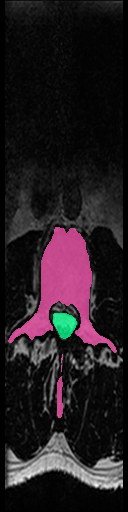

In [3]:
from tiger.screenshots import ScreenshotGenerator

# Configure the screenshot generator
generator = ScreenshotGenerator()

# Create the screenshot (the mask argument is optional)
screenshot = generator(image, mask)
display(screenshot)

By default, the screenshot generator will take the central slice along the z-axis. This works nicely, but the image looks a bit deformed. If we inspect the voxel spacing of the original 3D image, we can see that the in-plane spacing (x and y) is different from each other:

In [4]:
print(header['spacing'])

[0.91350993 0.46875    0.44184406]


If we tell the screenshot generator which resolution the screenshot should have and also inform it about the resolution of the 3D image, the screenshot will be resampled accordingly. Usually, an isotropic resolution makes most sense since the 2D screenshot is just a normal image with square pixels.

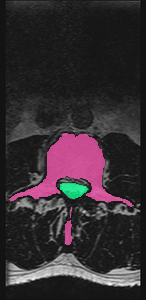

In [5]:
generator = ScreenshotGenerator(pixel_spacing=(0.8, 0.8))
screenshot = generator(image, mask, spacing=header['spacing'])
display(screenshot)

## Collages

Next, we will combine multiple screenshot generators to create a screenshot collage. This allows us to display multiple screenshots in a single image. The collage is configured by providing either a list of screenshot generators to create a collage with a single row of screenshots, or by providing a list of lists of generators to create a collage with multiple rows.

In the first example, three screenshots at different positions along the x-axis (`axis=0`) are displayed next to each other. The position of the screenshot is defined relative to the length of the axis (so `coordinate=0.3` means the slice at 30% of the axis length). Compared with using absolute coordinates like "30th slice", a relative coordinate makes it easier to use the same screenshot generator for images with different dimensions.

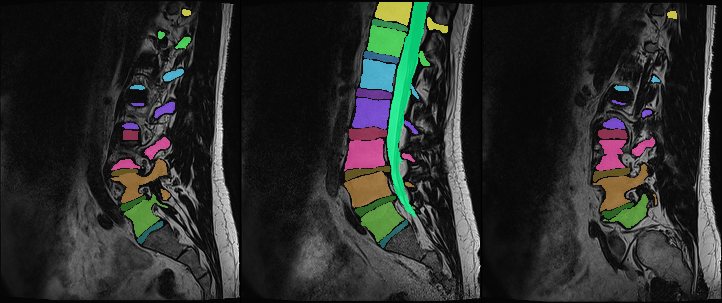

In [6]:
from tiger.screenshots import ScreenshotCollage

# Generate a screenshot collage at 30%, 50% and 70% along the x-axis
kwargs = {"axis": 0, "pixel_spacing": (1, 1)}
generator = ScreenshotCollage([
    ScreenshotGenerator(coordinate=0.3, **kwargs),
    ScreenshotGenerator(coordinate=0.5, **kwargs),
    ScreenshotGenerator(coordinate=0.7, **kwargs)
])

# Generating the screenshot works the same as with a single generator
screenshot = generator(image, mask, spacings=header['spacing'])
display(screenshot)

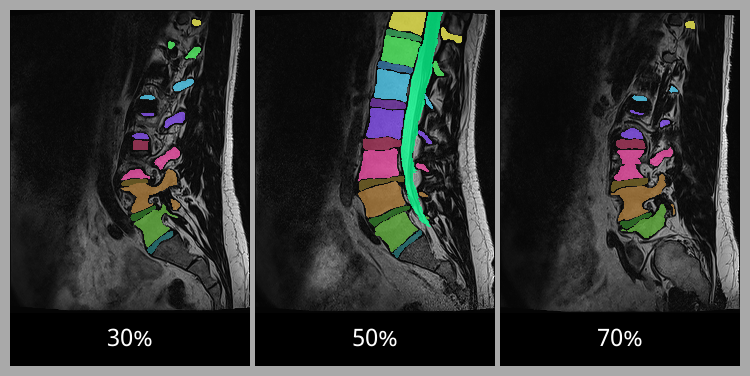

In [7]:
# Add captions and change spacing and background of the collage
kwargs = {"axis": 0, "pixel_spacing": (1, 1)}
generators = [
    ScreenshotGenerator(coordinate=0.3, caption="30%", **kwargs),
    ScreenshotGenerator(coordinate=0.5, caption="50%", **kwargs),
    ScreenshotGenerator(coordinate=0.7, caption="70%", **kwargs)
]
collage = ScreenshotCollage(generators, spacing=5, margin=10, background="darkgrey")
screenshot = collage(image, mask, spacings=header['spacing'])
display(screenshot)

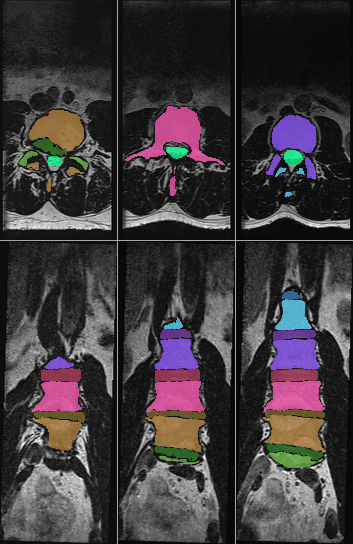

In [8]:
# Collage with multiple rows - use a list of lists to define the grid of screenshots
kwargs = {"pixel_spacing": (1, 1)}
generators = [
    [
        ScreenshotGenerator(axis=2, coordinate=coordinate, **kwargs)
        for coordinate in (0.35, 0.5, 0.65)
    ],
    [
        ScreenshotGenerator(axis=1, coordinate=coordinate, **kwargs)
        for coordinate in (0.475, 0.5, 0.525)
    ]
]
collage = ScreenshotCollage(generators, background="darkgrey")
screenshot = collage(image, mask, spacings=header['spacing'])
display(screenshot)

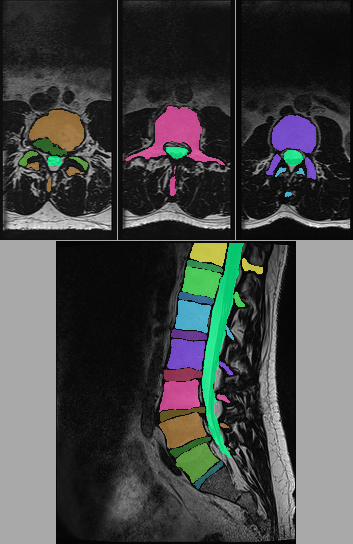

In [9]:
# The number of screenshots does not have to be the same in each row
kwargs = {"pixel_spacing": (1, 1)}
generators = [
    [
        # 3 screenshots in the first row
        ScreenshotGenerator(axis=2, coordinate=coordinate, **kwargs)
        for coordinate in (0.35, 0.5, 0.65)
    ],
    [
        # 1 screenshot in the second row
        ScreenshotGenerator(axis=0, **kwargs)
    ]
]
collage = ScreenshotCollage(generators,background="darkgrey")
screenshot = collage(image, mask, spacings=header['spacing'])
display(screenshot)

We can also use different masks for the overlays:

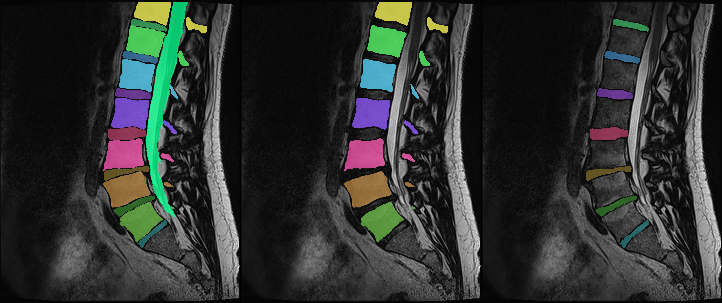

In [10]:
mask1, mask2, mask3 = mask, mask.copy(), mask.copy()
mask2[mask >= 100] = 0
mask3[mask < 200] = 0

generator = ScreenshotGenerator(axis=0, pixel_spacing=(1, 1))
collage = ScreenshotCollage([generator, generator, generator])
screenshot = collage(image, [mask1, mask2, mask3], spacings=header['spacing'])
display(screenshot)

Likewise, different images can be used by providing a list of images when invoking the generator rather than a single image.

## Window-level settings

By default, the contrast of the image is automatically determined based on the range of values in the image. It is also possible to use a fixed window/level setting:

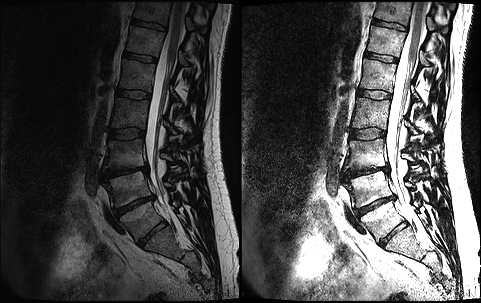

In [11]:
kwargs = {"axis": 0, "pixel_spacing": (1, 1)}
collage = ScreenshotCollage([
    ScreenshotGenerator(**kwargs),
    ScreenshotGenerator(window_level=(100, 50), **kwargs)
])
screenshot = collage(image, spacings=header['spacing'])
display(screenshot)

## Overlay settings

The colors of the overlay are determined using a lookup-table. There are a few pre-defined lookup-tables. Any callable that returns an RGBA color for a label can be used as well.

Furthermore, the opacity of the overlay can be changed.

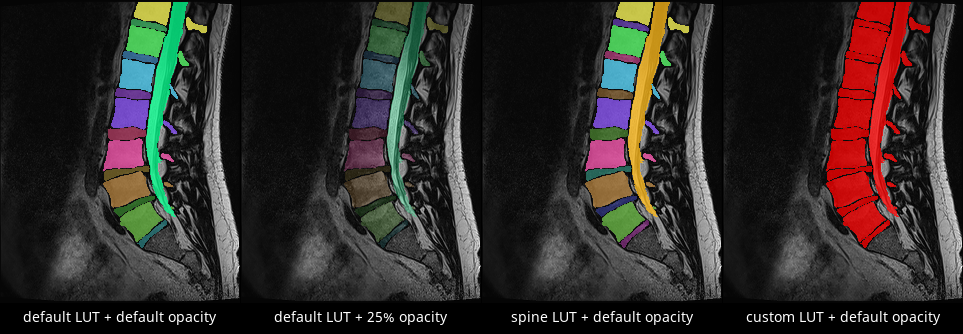

In [12]:
from tiger.screenshots import SpineColors

def custom_lut(label):
    opacity = 255 if label > 0 else 0
    return 255, 0, 0, opacity  # return the same color for all labels

kwargs = {"axis": 0, "pixel_spacing": (1, 1), "caption_size": 14}
collage = ScreenshotCollage([
    ScreenshotGenerator(caption="default LUT + default opacity", **kwargs),
    ScreenshotGenerator(overlay_opacity=0.25, caption="default LUT + 25% opacity", **kwargs),
    ScreenshotGenerator(overlay_lut=SpineColors(), caption="spine LUT + default opacity", **kwargs),
    ScreenshotGenerator(overlay_lut=custom_lut, caption="custom LUT + default opacity", **kwargs)
])
screenshot = collage(image, mask, spacings=header['spacing'])
display(screenshot)

## Slab thickness

Sometimes it helps to display thicker slabs (several slices averaged into one slice) instead of individual slices. This can be done on the fly:

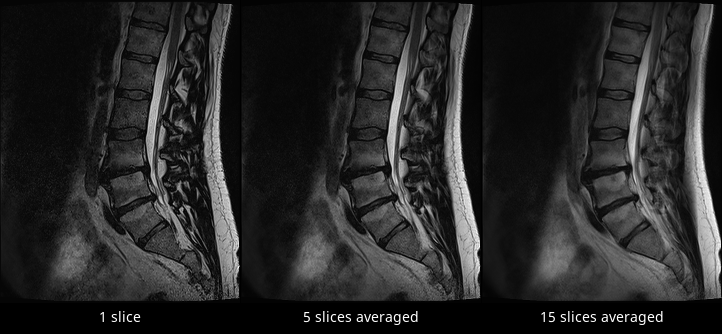

In [13]:
from tiger.screenshots import SpineColors

kwargs = {"axis": 0, "pixel_spacing": (1, 1), "caption_size": 14}
collage = ScreenshotCollage([
    ScreenshotGenerator(caption="1 slice", **kwargs),
    ScreenshotGenerator(slab_thickness=5, caption="5 slices averaged", **kwargs),
    ScreenshotGenerator(slab_thickness=15, caption="15 slices averaged", **kwargs)
])
screenshot = collage(image, spacings=header['spacing'])
display(screenshot)

## Maximum-intensity projection of the overlay

When screenshots are used to scan segmentation results, for example to find segmentation failures, it can be helpful to generate a MIP of the overlay. It will then not match the image anymore, but gives a quick overview of the segmentation result:

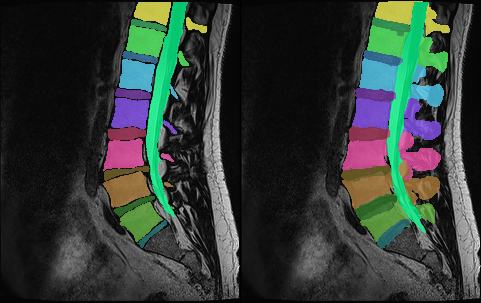

In [14]:
from tiger.screenshots import SpineColors

kwargs = {"axis": 0, "pixel_spacing": (1, 1)}
collage = ScreenshotCollage([
    ScreenshotGenerator(**kwargs),
    ScreenshotGenerator(overlay_mip=True, **kwargs),
])
screenshot = collage(image, mask, spacings=header['spacing'])
display(screenshot)

## Saving screenshots

The generated screenshots are PIL (Pillow) images, so saving them is trivial:

In [15]:
screenshot.save('filename.jpg')